# CSE 325/425 NLP
### Programming Assignment 1

You are asked to implement basic text pre-procssing and then define and train the Glove model. I removed parts of my implementation and you will need to complete them.

Your codes are evaluated based on

*   Correct and reasonable text preprocessing.
*   Convergence of the model training.
*   Interesting word embedding shown by visualization and word similarity.
*   Speeding up of the word indexing and model training.


In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
!pwd
os.chdir('gdrive/My Drive/research/Datasets/Amazon_UCSD')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/research/Datasets/Amazon_UCSD
glove.6B.300d.txt  hhh.png				      train_small.csv
glove_model_1.pt   json_to_csv.py			      valid_small.csv
glove_model_20.pt  reviews_Cell_Phones_and_Accessories_5.csv
glove_model_3.pt   test_small.csv


## Text Preprocessing and Dataset Construction

### Define the WordIndexer class to
*   hold the mapping from words to their indices and the indices to words.
*   fit_transform to map from a list of sentences to a list of integers so that words are mapped to their indices, in the input order.

### Inherit from the `torch.utils.data.Dataset` class and create the AmazonReviewGloveDataset class to


*   load the Amazon reviews in the csv format. Tokenize the reviews into sentences (a review can contain more than one sentence).
*   use the WordIndexer class to obtain the indices of the words in the sentences.
*   compute the X (word co-occurrence) matrix as the Glove paper indicates.

We provide the function to read the pretrained word vectors from text files.

In [2]:
import re
from collections import Counter
import pickle

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

cuda_use=True
def cuda(x):
    if cuda_use:
        return x.cuda()
    return x

class WordIndexer:
    """Transform a dataset of text to a list of index of words."""

    def __init__(self, min_word_occurences=10, oov_word="OOV"):
        """ min_word_occurrences: integer, the minimum frequency of the word to keep.
            oov_word: string, a special string for out-of-vocabulary words.
        """
        self.oov_word = oov_word
        self.min_word_occurences = min_word_occurences
        self.word_to_index = {oov_word: 0}
        self.index_to_word = [oov_word]
        self.word_occurrences = {}
        
        # for retaining only words
        self.re_words = re.compile(r"\b[a-zA-Z]{2,}\b")

    def get_word_index(self, word, add_new_word = True):
        """ Find the index of a word.
                
            word: string, the query word.
            add_new_word: if true, if the word has no entry, assign a new integer index to word.
                            if false, return the index of the oov_word
                            
            return: index of the query word
        """
        try:
            return self.word_to_index[word]
        except:
            if add_new_word:
                index = self.n_words
                self.word_to_index[word] = index
                self.index_to_word.append(word)
                return index
            else:
                return self.word_to_index[self.oov_word]

    @property
    def n_words(self):
        """ return: the vocabulary size
        """
        return len(self.word_to_index)

    def fit_transform(self, texts, use_existing_indexer = False):
        """ texts: list of sentences, each of which is a string
            use_existing_indexer: if true, don't create new indexer
            
            Split each sentence into a list of words.
            Then filter out the infrequent words.
            Other text preprocessing, such as
                lower-casing,
                stop-word removal, and
                advance word tokenization
                are possible here.
            Lastly setup the word-to-index and index-to-word dictionaries.
            
            return: a list of lists of indices of words in each sentence.
                    For example: [[1,2,3], [4,5,6]] where,
                        [1,2,3] are the indices of words in the first sentence
                        [4,5,6] are the indices of words in the second sentence
                    
        """
        ## Your codes go here
        # tokenize sentences into words, then lower-case, filter stop-words, numbers, etc. here
        
        stop_words = set(stopwords.words('english'))

        l_words=[]
        for sentence in texts:
            inter=sentence.lower()
            inter2=inter.split(' ')
            inter3=' '.join([word for word in inter2 if word not in stop_words])
            l_words.append(self.re_words.findall(inter3))

        
        ## when finish, print out the number of sentences.
        print (f'number of sentences: {len(l_words)}')
        
        mapped_word_to_indices = []
       
        ## Your codes go here
        # when a training corpus has been processed and you're processing
        # the validation and test corpora.
        if use_existing_indexer:
          for sentence in l_words:
              inter = [self.get_word_index(word, False) for word in sentence]
              mapped_word_to_indices.append(inter)
            # return the mapped word indices here
        
        ## Your codes go here
        # otherwise, filter out the infrequent words,
        # store the remained words and their frequencies in word_occurrences,
        # then build the mapping from words to indices and indices to words
        # lastly return the mapped word indices
        
        if not use_existing_indexer:

          all_words = []
          for sentence in l_words:
              all_words += sentence

          unique_words = Counter(all_words)

          self.word_occurrences={}
          for word, nb in unique_words.items():
              if nb >= self.min_word_occurences:
                  self.word_occurrences[word]=nb

          for sentence in l_words:
              inter=[self.get_word_index(word,True) if word in self.word_occurrences else self.word_to_index[self.oov_word] for word in sentence]
              mapped_word_to_indices.append(inter)
              
              
        return mapped_word_to_indices
        
class AmazonReviewGloveDataset(Dataset):
    def __init__(self, path, indexer = None, right_window = 10, min_word_occurences = 10):
        """ Load the reviews from a csv file. One row is one review.
                See train_small.csv for the format.
                
            path: path to the csv file containing the reviews and their ratings
            indexer: if None, build a new WordIndexer, otherwise use the one passed in.
            right_window: integer, how large the window is to get context words.
                        Looking into the right hand side of the center word only.
            min_word_occurrences: integer, the minimum frequency of the word to keep.
        """
        self.right_window = right_window
        
        # Step 1: tokenize the first field of each row into sentences
        #         (e.g. using nltk.tokenize.sent_tokenize).
        ## Your codes go here  
        
        data=pd.read_csv(path)
        data = data[pd.notnull(data['reviewText'])]
        reviews=data['reviewText']
        sentences=[]
        for i,review in enumerate(reviews):
            inter=nltk.tokenize.sent_tokenize(review)
            sentences+=inter
        
        
        # Step 2: pass the list of all sentences to WordIndexer.
        # turn list of sentences into list of lists of word indices in the sentences.
        # Keep the word ordering.
        print ('Indexing the corpus...')
        ## Your codes go here
        
        if indexer:
          self.indexer=indexer
          mapped_word_to_indices =self.indexer.fit_transform(sentences,True)
        else:
          self.indexer=WordIndexer(min_word_occurences,"OOV")
          mapped_word_to_indices = self.indexer.fit_transform(sentences,False)

        print ('Done indexing the corpus.')
        
        
        # Step 3: go through the corpus and gather (center, context) in comatrix,
        # which is a collections.Counter object.
        # keys are (center, context) pairs
        # values are the number of their co-occurrence as defined in the Glove paper.
        print ('Constructing the co-occurrence matrix...')
        ## Your codes go here
        cooccurences_matrix=Counter()
        for sentence in mapped_word_to_indices:
            for i, left_index in enumerate(sentence):
                window_to_use = sentence[i + 1:i + self.right_window + 1]
                for dist, right_index in enumerate(window_to_use):

                    cooccurences_matrix[(left_index, right_index)] += 1. / (dist+1)
                    
        
        
        # Step 4: linearize the entries in the co-occurrence matrix for mini-batch SGD training
        # a batch is a list of tuples (center, context, num_cooccurrences)
        # hint: store the center, context, and X_ij in three lists.
        ## Your codes go here
        
        self.left,self.right,self.n_occurrences=zip(*[(left_index, right_index, occ) for (left_index, right_index), occ in cooccurences_matrix.items()])

        self.n_occurrences = np.array(self.n_occurrences)
        
        print (f'Done constructing the co-occurrence matrix. Number of entries = {len(self.left)}')

        
    def __getitem__(self, t):
        """
            return: the t-th (center, context) word pair and their co-occurrence frequency.
        """
        ## Your codes go here
        return self.left[t],self.right[t],self.n_occurrences[t]
            
    def __len__(self):
        """
            return: the total number of (center, context) word pairs.
        """
        ## Your codes go here
        return len(self.left)
    
def load_pretrained_wv(path):
    wv = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            items = line.split(' ')
            wv[items[0]] = torch.DoubleTensor([float(a) for a in items[1:]])
    return wv

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Define the Glove model
The parameters include

*   Vectors of words when used as center and context words
*   Biases for the center and contexts words.

The parameters are defined for you already and please don't change the variable names.

There is an option to pass in pre-trained word vectors to replace random initialization of the word vectors in this model.

You have to complete the forward function to compute the predictions of log X_ij.



In [0]:
from torch import nn
import torch.functional as F

class GloveModel(nn.Module):
    def __init__(self, word_indexer, wv = None, word_dims = 300, BASE_STD = 0.01, random_state = 0):
        """ Specify and initialize the parameters of the Glove network.
        """
        super(GloveModel, self).__init__()
        num_words = word_indexer.n_words
        
        torch.manual_seed(random_state)
        
        # initialize left and right word vectors
        self.L_vecs = (torch.randn((num_words, word_dims))  * BASE_STD)
        self.R_vecs = (torch.randn((num_words, word_dims))  * BASE_STD)
        
        # initialize the left and right biases 
        self.L_bias = (torch.randn((num_words, )) * BASE_STD).requires_grad_()
        self.R_bias = (torch.randn((num_words, )) * BASE_STD).requires_grad_()
        
        if wv is not None:
            num_replaced = 0
            for i in range(num_words):
                word = word_indexer.index_to_word[i]
                if word in wv:
                    num_replaced += 1
                    self.L_vecs[i] = wv[word]
                    self.R_vecs[i] = wv[word]
            print (f'Replaced {float(num_replaced) / num_words}')
            
        self.L_vecs.requires_grad_()
        self.R_vecs.requires_grad_()
        
        # gather the trainable parameters
        self.parameters = [self.L_vecs, self.R_vecs, self.L_bias, self.R_bias]
        
    def forward(self, left_indices, right_indices):
        """ Implement w_i^t w_j + b_i + b_j (the left-hand-side of Eq. (7) in the Glove paper)
        
            left_indices: torch.Tensor, a batch of center words
            right_indices: torch.Tensor, a batch of context words, of the same shape of left_indices.
            
            left_indices[i] and right_indices[i] is the i-th pair in the training data.
            
            return: torch.Tensor of the same shape of left_indices
        """
        ## Your codes go here
        
        left_vecs = self.L_vecs[left_indices]
        right_vecs = self.R_vecs[right_indices]
        left_bias = self.L_bias[left_indices]
        right_bias = self.R_bias[right_indices]

        vec_mul = (left_vecs * right_vecs).sum(1).view(-1)
        result = vec_mul + left_bias + right_bias

        return result

## Model training, validating, and saving

### First define some constants
Don't modify the codes here. 
You program should use these path defined here.




In [4]:
import torch
from tqdm import tqdm

# this will automatically place all tensor on GPU with type Double.
# if you are not running on GPU, change this line to
# torch.set_default_tensor_type('torch.DoubleTensor')
torch.set_default_tensor_type('torch.cuda.DoubleTensor')

# set up a couple of parameters and hyper-parameters

NUM_EPOCH = 25
BATCH_SIZE = 512

NUM_DIMS = 300

WINDOW_SIZE = 10

# two hyper-parameters in Eq. (9) of the paper
x_max = 100
alpha = 0.75

all_train = './reviews_Cell_Phones_and_Accessories_5.csv'

train_path = './train_small.csv'
valid_path = './valid_small.csv'
test_path = './test_small.csv'

save_path = './glove_model_{}.pt'

pretrained_wv = './glove.6B.{}d.txt'.format(NUM_DIMS)
print (pretrained_wv)

./glove.6B.300d.txt


In [0]:
# load pretrained word vectors
wv = load_pretrained_wv(pretrained_wv)

In [0]:
print (wv['good'])

tensor([-1.3602e-01, -1.1594e-01, -1.7078e-02, -2.9256e-01,  1.6149e-02,
         8.6472e-02,  1.5759e-03,  3.4395e-01,  2.1661e-01, -2.1366e+00,
         3.5278e-01, -2.3909e-01, -2.2174e-01,  3.6413e-01, -4.5021e-01,
         1.2104e-01, -1.5596e-01, -3.8906e-02, -2.9419e-03,  1.6009e-02,
        -1.1620e-01,  3.8680e-01,  3.5109e-01,  9.7426e-02, -1.2425e-02,
        -1.7864e-01, -2.3259e-01, -2.6960e-01,  4.1083e-02, -7.6194e-02,
        -2.3362e-01,  2.0919e-01, -2.7264e-01,  5.4967e-02, -1.8055e+00,
         5.6348e-01, -1.2778e-01,  2.3147e-01, -5.8820e-03, -2.6630e-01,
         4.1187e-01, -3.7162e-01, -2.0600e-01, -1.9619e-01, -4.3945e-03,
         1.2513e-01,  4.6638e-01,  4.5159e-01, -1.5000e-01,  5.9589e-03,
         5.9070e-02, -4.1440e-01,  6.1035e-02, -2.1117e-01, -4.0988e-01,
         5.6393e-01,  2.3021e-01,  2.7240e-01,  4.9364e-02,  1.4239e-01,
         4.1841e-01, -1.3983e-01,  3.4826e-01, -1.0745e-01, -2.5002e-01,
        -3.2554e-01,  3.3343e-01, -3.5617e-01,  2.0

### Then define the training, validation, and test data.
*   Use the AmazonReviewGloveDataset class to read in reviews in the train, valid, test sets.
*   You have the option to read the larger csv file using the all_train.
*   Define DataLoader wrapping around the Dataset objects



In [6]:
# load text data and turn them into a DataLoader object.
train_dataset = AmazonReviewGloveDataset(train_path, right_window = WINDOW_SIZE)
train_iter = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

# use training data's word indexer for validation and test datasets
valid_dataset = AmazonReviewGloveDataset(valid_path, train_dataset.indexer)
valid_iter = DataLoader(valid_dataset, batch_size = BATCH_SIZE * 4, shuffle = False)

test_dataset = AmazonReviewGloveDataset(test_path, train_dataset.indexer)
test_iter = DataLoader(test_dataset, batch_size = BATCH_SIZE * 4, shuffle = False)

# Or, run Glove on the bigger one
#train_dataset = AmazonReviewGloveDataset(all_train, right_window = WINDOW_SIZE)
#train_iter = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

Indexing the corpus...
number of sentences: 93506
Done indexing the corpus.
Constructing the co-occurrence matrix...
Done constructing the co-occurrence matrix. Number of entries = 1723083
Indexing the corpus...
number of sentences: 18238
Done indexing the corpus.
Constructing the co-occurrence matrix...
Done constructing the co-occurrence matrix. Number of entries = 428740
Indexing the corpus...
number of sentences: 26108
Done indexing the corpus.
Constructing the co-occurrence matrix...
Done constructing the co-occurrence matrix. Number of entries = 612641


### Third, start training.

*   You're required to use GPU to train the network, since GPU are ubiquitous (colab or SandBox).
*   Complete the function train_and_validate.



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveModel(train_dataset.indexer, wv, word_dims = NUM_DIMS)

# make sure you use weight_decay to activate the L2 regularization
optimizer = torch.optim.Adam(model.parameters, weight_decay=1e-8)

def train_and_validate(train_iter, valid_iter = None):
    best_loss = np.inf
    best_epoch = -1
    to_save = {}
    
    for epoch in range(NUM_EPOCH):
        model.train()
        epoch_loss = 0
        num_batches = len(train_iter)
        for l, r, n_lr in train_iter:
            optimizer.zero_grad()
            
            # Implement the loss function in Eq. (8) of the paper, in three steps.
            # Step 1. find the prediction of log(X_ij) using the network
            ## Your codes go here
            
            log_xij = cuda(np.log(n_lr))
            pred=model.forward(l,r)

            
            # Step 2. compute the weights f(X_ij)
            ## Your codes go here
            
            weights = np.minimum((n_lr / x_max) ** alpha, 1)
            weights = cuda(weights)

            
            # Step 3. compute the loss using the predictions and the weights
            ## Your codes go here

            diff = (pred - log_xij) ** 2
            loss = torch.mul(diff, weights)
            loss=loss.mean()
            epoch_loss += loss.item()
            # gradient descent
            loss.backward()
            optimizer.step()
            
        # I want to see the training is progressing so don't remove the following line.
        print(f'Training epoch = {epoch}, epoch loss = {epoch_loss / num_batches}')
        
        # validate the model on validation set and record the best model.
        # this optional, you can also save the final model.
        ## Your codes go here
        
        # enter evaluation mode, no need for grads to make it run faster
        with torch.no_grad():
            model.eval()
            eval_loss=0
            num_batches = len(valid_iter)
            for l, r, n_lr in valid_iter:
                log_xij = cuda(np.log(n_lr))
                pred = model.forward(l, r)
                weights = np.minimum((n_lr / x_max) ** alpha, 1)
                weights = cuda(weights)
                diff = (pred - log_xij) ** 2
                loss = torch.mul(diff, weights)
                loss = loss.mean()
                eval_loss += loss.item()


            eval_loss_ = eval_loss / num_batches
            print('Validation loss = {}'.format(eval_loss_))

            if eval_loss_ < best_loss:
                best_loss = eval_loss_
                best_epoch = epoch

                # record the model state_dict() for saving later
                to_save = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict()
                }

        

        # record the model state_dict() for saving later
        #to_save = {
        #    'epoch': epoch,
        #    'model_state_dict': model.state_dict()
        #}
        #torch.save(to_save, save_path.format(epoch))
        
    # report and save the best model
    print(f'best epoch = {best_epoch} with the best validation loss = {best_loss}')
    torch.save(to_save, save_path.format(best_epoch))
    return best_epoch
    
best_epoch=train_and_validate(train_iter, valid_iter = valid_iter)

Replaced 0.9833239647742177
Training epoch = 0, epoch loss = 0.6503555694551025
Validation loss = 0.199209179378955
Training epoch = 1, epoch loss = 0.12579548205587202
Validation loss = 0.08519512252280553
Training epoch = 2, epoch loss = 0.05522983875892927
Validation loss = 0.06006617481531751
Training epoch = 3, epoch loss = 0.032293131836195574
Validation loss = 0.05006274686067009
Training epoch = 4, epoch loss = 0.021386346650692313
Validation loss = 0.04519247319582106
Training epoch = 5, epoch loss = 0.015189381845453234
Validation loss = 0.041988724851835704
Training epoch = 6, epoch loss = 0.011273474952767116
Validation loss = 0.04011593363736913
Training epoch = 7, epoch loss = 0.008692613521221436
Validation loss = 0.038541004765931454
Training epoch = 8, epoch loss = 0.006966525335773243
Validation loss = 0.038054242663450887
Training epoch = 9, epoch loss = 0.005861776773813776
Validation loss = 0.03777032677794495
Training epoch = 10, epoch loss = 0.005121561472196799


## We provide to pieces of codes to see the trained word vectors.
### Visualize the learned word vectors
### Retrieve the similar words

Use these two functionalities to see what you're model has learned.

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def load_model(save_path, indexer):
    model = GloveModel(indexer, word_dims = NUM_DIMS)

    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']

    # move the model to GPU if has one
    model.to(device)

    # need this for dropout
    model.eval()
    return model

def plot_2d(label, embeddings, words=[], a=1):
    """ Plot the word vectors projected to 2D.
        Source codes taken from:
        https://gist.github.com/sismetanin/6c2c398ec719a1958b0dc2bca653f9eb#file-tsne-word2vec-2d-anna-karenina-py
        
        embeddings: word vectors projected to 2D
        words: list of words to label the points.
    """
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()
    

glove = load_model(save_path.format(best_epoch), train_dataset.indexer)
# avg_word_vectors = (glove.L_vecs.to('cpu') + glove.R_vecs.to('cpu')) / 2
# print (avg_word_vectors.device)
# print (avg_word_vectors.size())
# print (train_dataset.indexer.n_words)
embeddings_ak = glove.L_vecs.to('cpu').detach().numpy()

# read this article before you start visualization

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(embeddings_ak)

tsne_ak_2d = TSNE(perplexity = 500, n_iter = 1000)
# this can take a while
embeddings_ak_2d = tsne_ak_2d.fit_transform(pca_result_50)

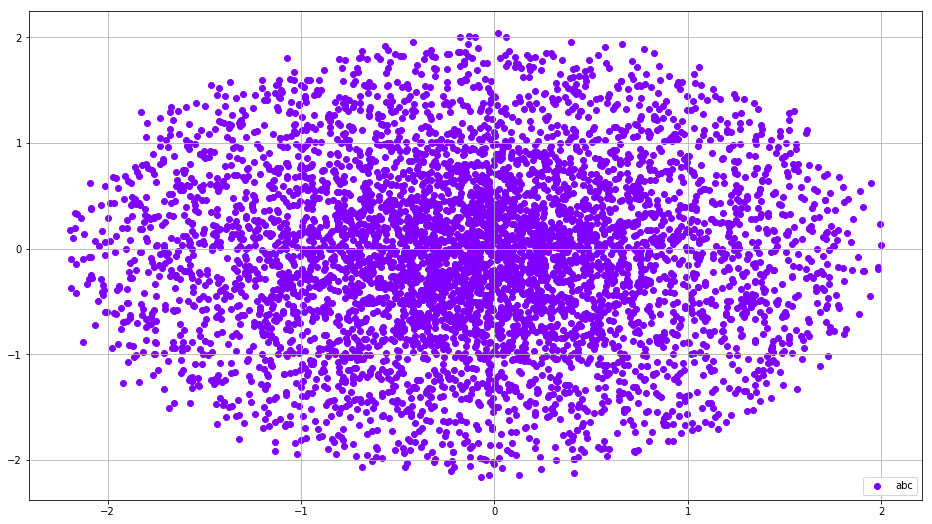

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline


plot_2d('abc',embeddings_ak_2d)

## Retrieve similar words

In [10]:
from sklearn.preprocessing import normalize

test_aspect_words = ['phone', 'case', 'battery', 'headset', 'charger', 'quality', 'screen', 'bluetooth', 'price', 'device']
test_sentimental_words = ['great', 'good', 'well', 'works', 'better', 'little', 'easy', 'nice', 'new', 'long']

glove = load_model(save_path.format(best_epoch), train_dataset.indexer)
avg_word_vectors = (glove.L_vecs.to('cpu') + glove.R_vecs.to('cpu')) / 2
avg_word_vectors = avg_word_vectors.detach().numpy()

n_words = train_dataset.indexer.n_words

row_normalized = normalize(avg_word_vectors)
sim = row_normalized.dot(row_normalized.T)

for w in test_aspect_words:
    w_idx = train_dataset.indexer.word_to_index[w]
    l = []
    for i in range(n_words):
        l.append((i, sim[w_idx, i]))
    l = sorted(l, key = lambda x:x[1], reverse = True)
    for i in range(10):
        print (f'{train_dataset.indexer.index_to_word[l[i][0]]}: {l[i][1]}')
        
for w in test_sentimental_words:
    w_idx = train_dataset.indexer.word_to_index[w]
    l = []
    for i in range(n_words):
        l.append((i, sim[w_idx, i]))
    l = sorted(l, key = lambda x:x[1], reverse = True)
    for i in range(10):
        print (f'{train_dataset.indexer.index_to_word[l[i][0]]}: {l[i][1]}')

phone: 1.0000000000000004
presentations: 0.22905505840123266
provider: 0.18615713367653772
squeegee: 0.1842385450143291
placed: 0.18010832703067958
sample: 0.17571310151610983
dedicated: 0.17566444730986908
jawbone: 0.17279946577977337
nokia: 0.1716376743583436
pogo: 0.16644378534259907
case: 0.9999999999999998
cleanly: 0.2156991448943768
internet: 0.21234989345460165
music: 0.19106040834300744
total: 0.18790041546971856
stitching: 0.18678758184958316
faint: 0.18264020419377666
onto: 0.17792095418507567
kudos: 0.1764882087735135
fitted: 0.17369497859998562
battery: 1.0
unacceptable: 0.24290167053178785
collection: 0.21164511857218013
usb: 0.2091494186976006
downsides: 0.1906257816807697
overnight: 0.18090560692526433
shortcut: 0.1767652471882724
films: 0.1726008479049942
trash: 0.17167431287568727
saver: 0.1684069217874285
headset: 0.9999999999999998
opportunity: 0.2083250590903123
identify: 0.19882802429604207
auxiliary: 0.1904484210854456
researching: 0.18338458300881533
plain: 0.182